In [1]:
import warnings
warnings.filterwarnings('ignore')   # do not disturbe mode

import numpy as np  # vectors and matrices
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta    # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf    # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
# MAPE function to calculate Mean Absolute Percentage Error

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculates the Mean Absolute Percentage Error (MAPE) between two arrays.

    Args:
        y_true (numpy.ndarray): The actual values.
        y_pred (numpy.ndarray): The predicted values.

    Returns:
        float: The MAPE as a percentage.
    """

    # Calculate absolute percentage error for each prediction
    absolute_percentage_errors = np.abs((y_true - y_pred) / y_true) * 100

    # Return the mean of the absolute percentage errors
    return np.mean(absolute_percentage_errors)


def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
    Plots time series data, its Autocorrelation Function (ACF), 
    Partial Autocorrelation Function (PACF), and calculates the Dickey-Fuller test statistic.

    Args:
        y (pandas.Series): The time series data.
        lags (int, optional): The number of lags to consider for ACF and PACF plots. Defaults to None (uses default lag calculation).
        figsize (tuple, optional): The figure size (width, height) for the plot. Defaults to (12, 7).
        style (str, optional): A plotting style from matplotlib. Defaults to 'bmh' (black and white with markers).
    """

    if not isinstance(y, pd.Series):
        # Convert y to pandas Series if not already
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        # Plot the time series
        y.plot(ax=ts_ax)

        # Calculate and display Dickey-Fuller test p-value
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(f'Time Series Analysis Plots\n Dickey-Fuller: p={p_value:.5f}')

        # Plot ACF and PACF
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

    plt.tight_layout()

In [3]:
# Let's look at real mobile game data. Specifically, we will look into ads watched per hour and in-game currency spend per day:
ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time'])

Plot Time Series Data

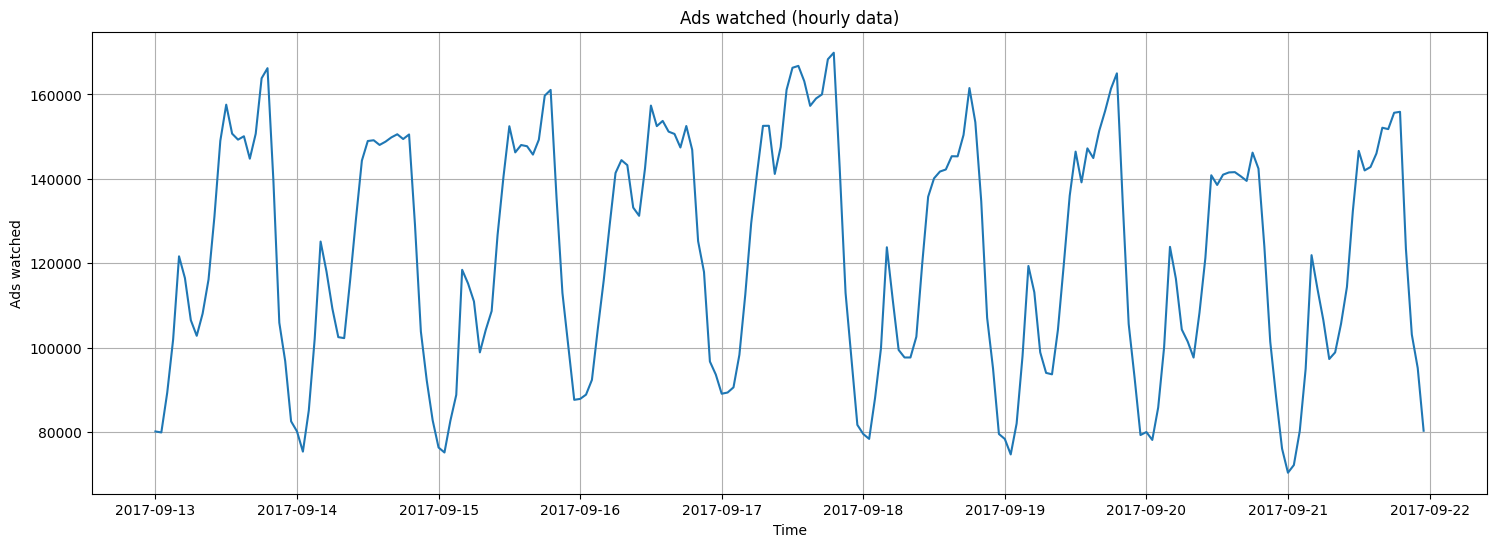

In [4]:
plt.figure(figsize=(18, 6))
plt.plot(ads.Ads)
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xlabel('Time')
plt.ylabel('Ads watched')
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

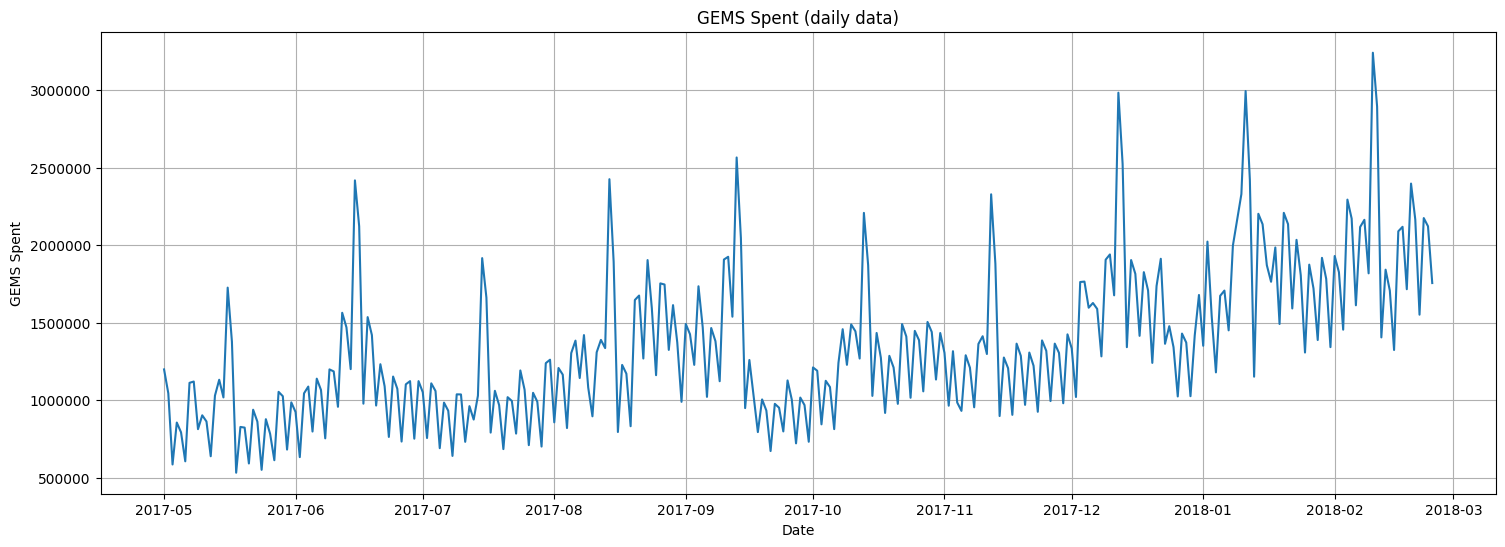

In [5]:
plt.figure(figsize= (18,6))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.gca().ticklabel_format(axis='y', style='plain')
plt.xlabel('Date')
plt.ylabel('GEMS Spent')
plt.title('GEMS Spent (daily data)')
plt.grid(True)
plt.show()

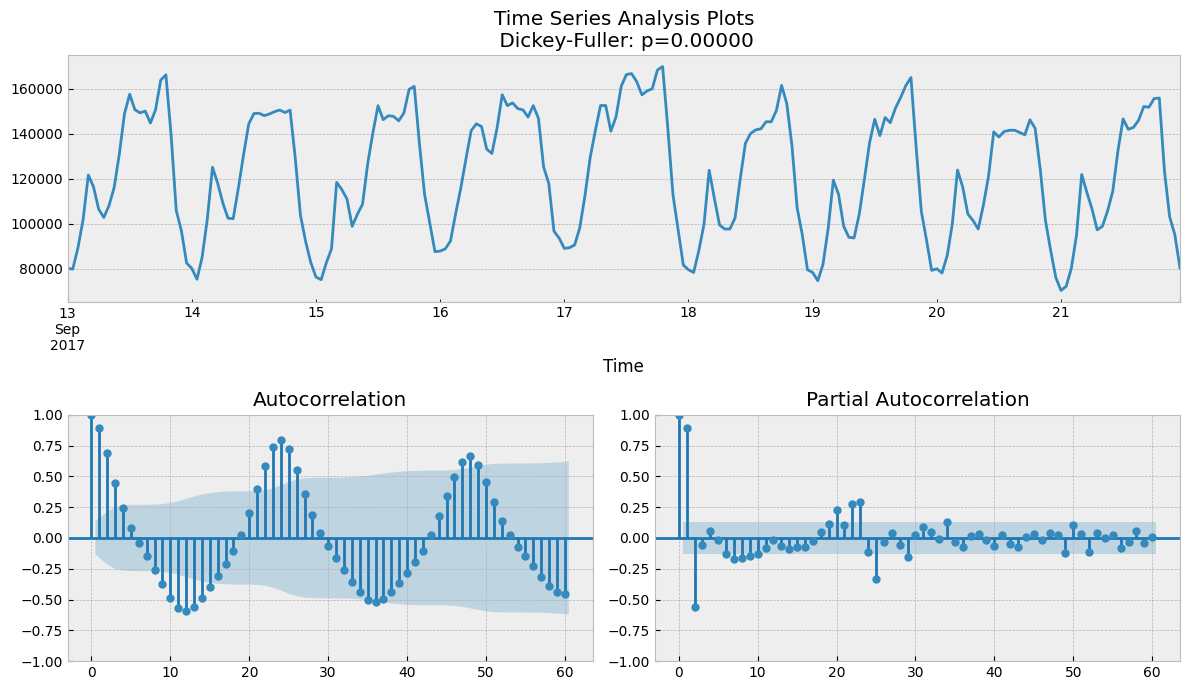

In [6]:
tsplot(ads.Ads, lags=60)

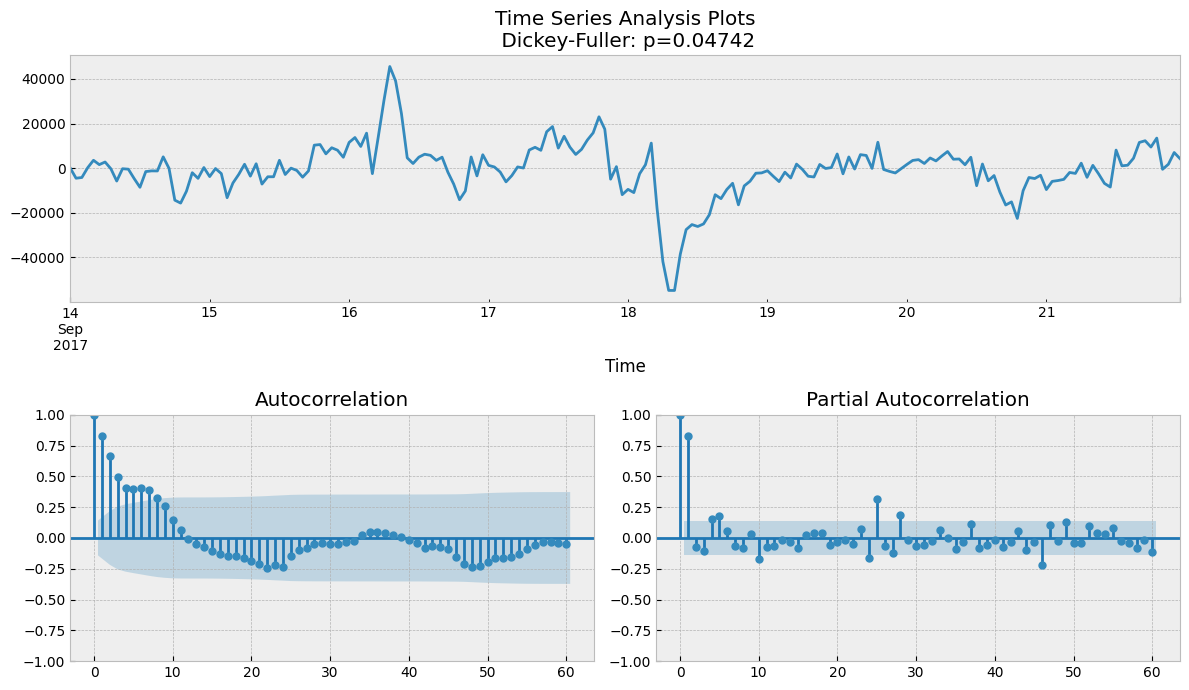

In [7]:
# The seasonal difference
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

It is now much better with the visible seasonality gone. However, the autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1.

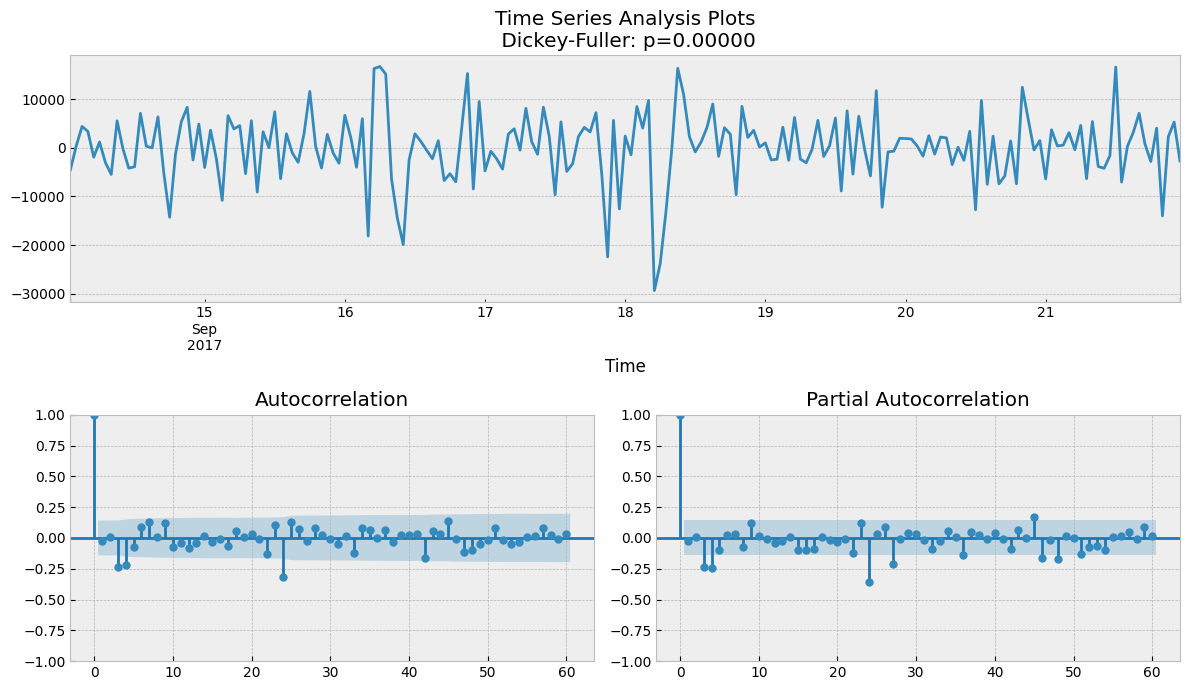

In [8]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

SARIMA parameters <br>
p is most probably 4 since it is the last significant lag on the PACF, after which, most others are not significant. <br>
d equals 1 because we had first differences <br>
q should be somewhere around 4 as well as seen on the ACF <br>
P might be 2, since 24-th and 48-th lags are somewhat significant on the PACF <br>
D again equals 1 because we performed seasonal differentiation <br>
Q is probably 1. The 24-th lag on ACF is significant while the 48-th is not <br>

In [9]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [10]:
def optimizeSARIMA(y, parameters_list, d, D, s):
    """
    This function optimizes a Seasonal ARIMA (SARIMA) model for a given time series data (`y`). 
    It evaluates different parameter combinations (`parameters_list`) and returns a DataFrame 
    containing the evaluated parameters and their corresponding Akaike Information Criterion (AIC) values.

    Args:
        y (pd.Series): The time series data to be modeled.
        parameters_list (list): A list of tuples containing different parameter combinations 
                                for the SARIMA model (p, q, P, Q).
            - p: The number of autoregressive (AR) terms.
            - q: The number of integrated moving average (MA) terms.
            - P: The number of seasonal AR terms.
            - Q: The number of seasonal MA terms.
        d (int): The order of differencing for the non-seasonal part of the data.
        D (int): The order of seasonal differencing.
        s (int): The number of observations in each season.
    
    Returns:
        pd.DataFrame: A DataFrame containing the evaluated parameters and their corresponding AIC values, 
                      sorted by AIC in ascending order (lower AIC indicates a better model).
    """

    results = []  # List to store evaluation results (parameters and AIC)
    best_aic = float("inf")  # Initialize best AIC to positive infinity

    for param in tqdm_notebook(parameters_list):
        # Try-except block to handle potential model convergence issues
        try:
            model = sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            print(f"Warning: Model failed to converge for parameters: {param}")
            continue

        aic = model.aic
        
        # Update best model, AIC, and parameters if current model has lower AIC
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, aic])

    # Create DataFrame from results and set column names
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']

    # Sort DataFrame by AIC (ascending) and reset index
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [11]:
%%time
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(ads.Ads, parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 5min 43s, sys: 1.96 s, total: 5min 45s
Wall time: 3min


In [12]:
result_table.head()

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849


In [15]:
# Extract best parameters from optimization results
p, q, P, Q = result_table.parameters[0]

# Create the best SARIMA model based on optimized parameters
best_model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

# Print summary of the best model
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -1936.321
Date:                              Sun, 02 Jun 2024   AIC                           3888.642
Time:                                      02:27:37   BIC                           3914.660
Sample:                                  09-13-2017   HQIC                          3899.181
                                       - 09-21-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.55

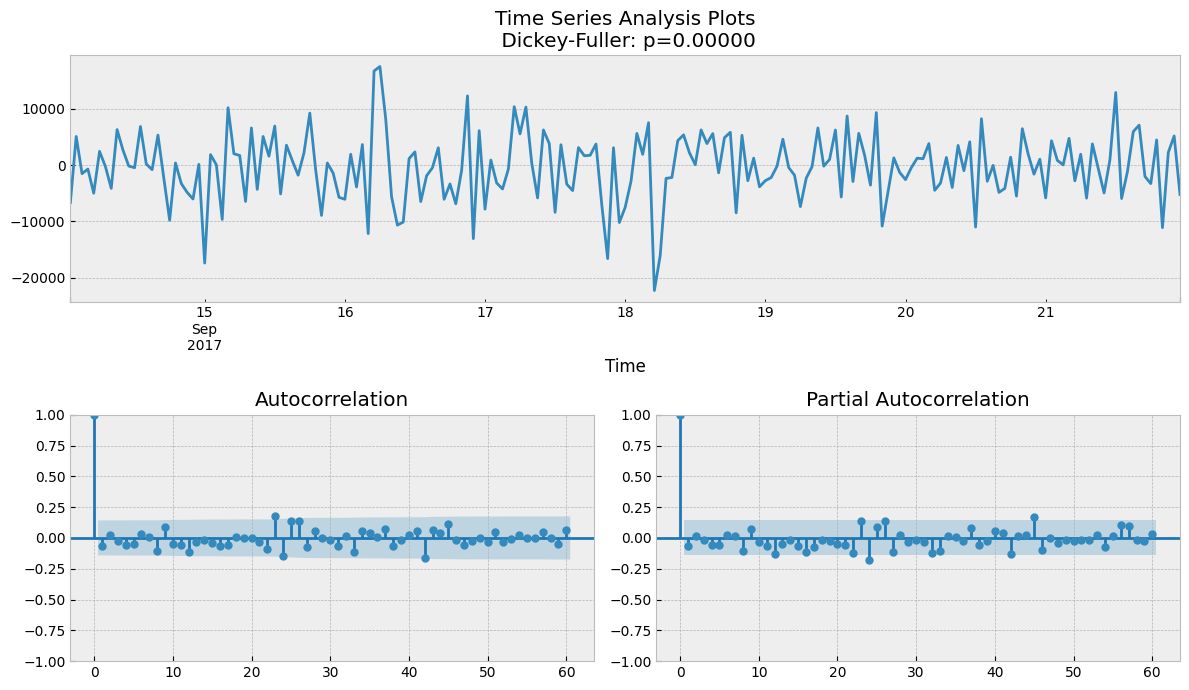

In [14]:
tsplot(best_model.resid[24+1:], lags=60)

In [28]:
def plotSARIMA(series, model, n_steps):
    """Plots the actual values, predicted values (fitted and forecast), 
       and calculates the Mean Absolute Percentage Error (MAPE) for the fitted model.
    
    Args:
        series (pd.Series): The time series data to be plotted.
        model (statsmodels.tsa.statespace.SARIMAX): The fitted SARIMA model.
        n_steps (int): The number of steps to predict in the future.
    """

    # Combine actual data and fitted values from the model
    data = series.copy()  # Create a copy to avoid modifying original data
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues

    # Adjust fitted values to account for differencing
    data['sarima_model'][: s + d] = np.NaN  # Set initial values (affected by differencing) to NaN
    
    # Forecast future values
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
     # Combine fitted and forecast values into a DataFrame
    forecast_df = pd.DataFrame(forecast, columns=['sarima_model'])
    combined_data = pd.concat([data, forecast_df], ignore_index=True)  # Concatenate DataFrames

    #forecast = data['sarima_model'].concat(forecast)  # Combine fitted and forecast values

    # Calculate MAPE, excluding initial values affected by differencing
    error = mean_absolute_percentage_error(data['actual'][s + d:], data['sarima_model'][s + d:])

    # Create the plot
    plt.figure(figsize=(15, 7))
    plt.title(f"Mean Absolute Percentage Error: {error:.2f}%")
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey', label='forecast')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

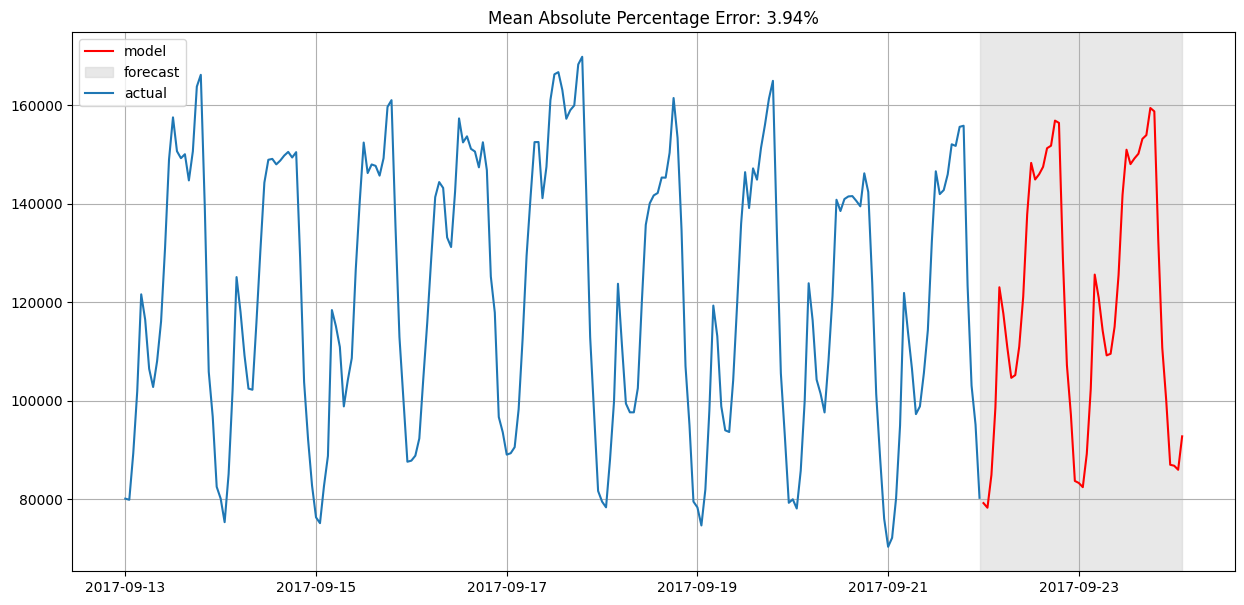

In [29]:
plotSARIMA(ads, best_model, 50)